Modified from https://lectures.quantecon.org/jl/markov_asset.html

## Markov growth, risk neutral pricing
First, create a markov chain

In [33]:
using QuantEcon
n = 5
#This generates a finite-space markov chain approximation for:
#  y_t = 0.96 y_{t-1} + 0.25 \epsilon_t
#  where \epsilon_t \sim N (0, 1)

mc = tauchen(n, 0.96, 0.25) #uses n nodes
@show mc.state_values
mc.p

mc.state_values = [-2.67857, -1.33929, 0.0, 1.33929, 2.67857]


5×5 Array{Float64,2}:
 0.987776     0.0122245    1.39888e-14  0.0          0.0        
 0.00190877   0.991227     0.00686433   2.66454e-15  0.0        
 4.65177e-16  0.00369685   0.992606     0.00369685   4.44089e-16
 5.82887e-40  2.61136e-15  0.00686433   0.991227     0.00190877 
 2.7914e-75   9.75194e-39  1.40111e-14  0.0122245    0.987776   

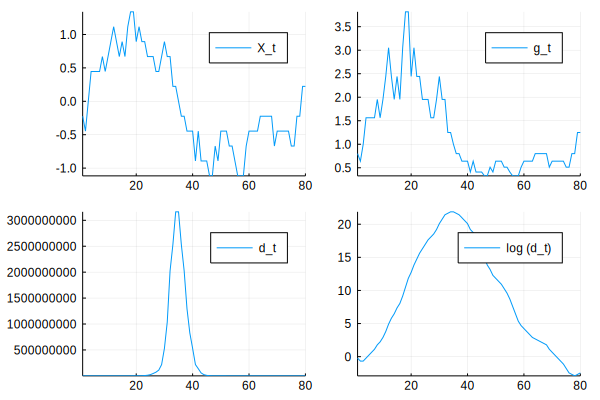

In [3]:
using Plots
n = 25
#This generates a finite-space markov chain approximation for:
#  y_t = 0.96 y_{t-1} + \epsilon_t
#  where \epsilon_t \sim N (0, 0.25^2)

mc = tauchen(n, 0.96, 0.25) #uses n nodes

sim_length = 80
x_0_index = round(Int64, n / 2) #Start at the middle state.  Round to nearest integer

#Simulate underlying state
x_series = simulate(mc, sim_length; init=x_0_index)

#g_t = exp(X_t) from the example
g_series = exp.(x_series)

#From d_{t+1} = g_t d_t.  cumprod does the cumulative product
d_0 = 1.0
d_series = d_0 * cumprod(g_series) #i.e. cumprod([1 2 3 4]) -> [1 2 6 24]

#Plotting the series for all, including the log of the dividends.
series = [x_series g_series d_series log.(d_series)]
labels = ["X_t" "g_t" "d_t" "log (d_t)"]
plot(series, layout=4, labels=labels)

## Pricing
Let $v_t$ be the price dividend ratio for the ex-dividend
$$
v(X_t) = \beta E_t\left[g(X_{t+1})(1 + v(X_{t+1})\right]
$$
For a discrete-state problem, this can be reduced to the system
$$v = \beta K(1+v)$$
with $K(x,y) = g(y)P(x,y)$ from (9)

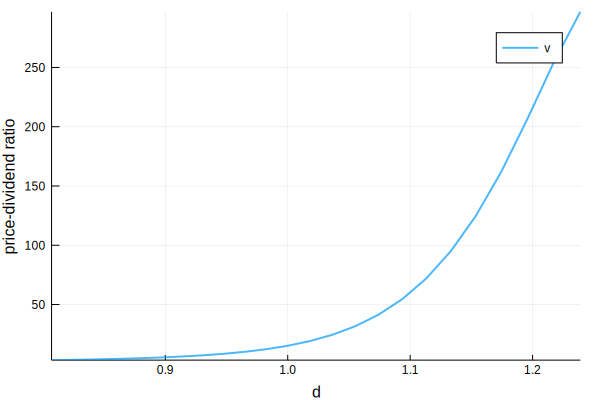

In [36]:
n = 25
mc = tauchen(n, 0.96, 0.02) #uses n nodes x_{t+1} = 0.96 x_t + 0.02 epsilon_t, where epsilon_t ~ N(0,1)
P = mc.p #Extract transition matrix
x = mc.state_values'  #Extract the states

#Details for the dividend process and utility
β = 0.9
g(x) = exp(x) #The g function given a state

K = P .* g.(x)' # equation 8


@assert maximum(abs, eigvals(K)) < 1/β #Otherwise unstable
one_column = ones(n, 1)
v = (I - β * K) \  (β * K * one_column) #equation 10

d = g.(x) #The dividends d_t = g(x_t)
plot(d', v, lw=2, ylabel="price-dividend ratio", xlabel="d", alpha=0.7, label="v")

In [ ]:
using QuantEcon

# A default Markov chain for the state process
ρ = 0.9
σ = 0.02
n = 25
default_mc = tauchen(n, ρ, σ)

mutable struct AssetPriceModel{TF<:AbstractFloat, TI<:Integer}
    β :: TF            # Discount factor
    γ :: TF            # Coefficient of risk aversion
    mc :: MarkovChain  # State process
    n :: TI            # Number of states
    g :: Function      # Function mapping states into growth rates
end

function AssetPriceModel(;β::AbstractFloat=0.96, γ::AbstractFloat=2.0,
                          mc::MarkovChain=default_mc, g::Function=exp)
    n = size(mc.p)[1]
    return AssetPriceModel(β, γ, mc, n, g)
end


"""
Stability test for a given matrix Q.
"""
function test_stability(ap::AssetPriceModel, Q::Matrix)
    sr = maximum(abs, eigvals(Q))
    if sr >= 1 / ap.β
        msg = "Spectral radius condition failed with radius = $sr"
        throw(ArgumentError(msg))
    end
end


"""
Computes the price-dividend ratio of the Lucas tree.

"""
function tree_price(ap::AssetPriceModel)
    # == Simplify names, set up matrices  == #
    β, γ, P, y = ap.β, ap.γ, ap.mc.p, ap.mc.state_values
    y = reshape(y, 1, ap.n)
    J = P .* ap.g.(y).^(1 - γ)

    # == Make sure that a unique solution exists == #
    test_stability(ap, J)

    # == Compute v == #
    I = eye(ap.n)
    Ones = ones(ap.n)
    v = (I - β * J) \ (β * J * Ones)

    return v
end

In [ ]:
using Plots, LaTeXStrings
pyplot()

γs = [1.2, 1.4, 1.6, 1.8, 2.0]
ap = AssetPriceModel()
states = ap.mc.state_values

lines = []
labels = []

for γ in γs
    ap.γ = γ
    v = tree_price(ap)
    label="γ = $γ"
    push!(labels, label)
    push!(lines, v)
end

plot(lines,
    labels=reshape(labels, 1, length(labels)),
    title="Price-dividend ratio as a function of the state",
    ylabel="price-dividend ratio",
    xlabel="state")

In [ ]:
"""
Computes price of a consol bond with payoff ζ

"""
function consol_price(ap::AssetPriceModel, ζ::AbstractFloat)
    # == Simplify names, set up matrices  == #
    β, γ, P, y = ap.β, ap.γ, ap.mc.p, ap.mc.state_values
    y = reshape(y, 1, ap.n)
    M = P .* ap.g.(y).^(-γ)

    # == Make sure that a unique solution exists == #
    test_stability(ap, M)

    # == Compute price == #
    I = eye(ap.n)
    Ones = ones(ap.n)
    p = (I - β * M) \ ( β * ζ * M * Ones)

    return p
end

In [ ]:
"""
Computes price of a perpetual call option on a consol bond.

"""
function call_option(ap::AssetPriceModel, ζ::AbstractFloat, p_s::AbstractFloat, ϵ=1e-7)

    # == Simplify names, set up matrices  == #
    β, γ, P, y = ap.β, ap.γ, ap.mc.p, ap.mc.state_values
    y = reshape(y, 1, ap.n)
    M = P .* ap.g.(y).^(-γ)

    # == Make sure that a unique console price exists == #
    test_stability(ap, M)

    # == Compute option price == #
    p = consol_price(ap, ζ)
    w = zeros(ap.n, 1)
    error = ϵ + 1
    while (error > ϵ)
        # == Maximize across columns == #
        w_new = max.(β * M * w, p - p_s)
        # == Find maximal difference of each component and update == #
        error = maximum(abs, w - w_new)
        w = w_new
    end

    return w
end

In [ ]:
ap = AssetPriceModel(β=0.9)
ζ = 1.0
strike_price = 40.0

x = ap.mc.state_values
p = consol_price(ap, ζ)
w = call_option(ap, ζ, strike_price)

plot(x, p, color="blue", lw=2, xlabel="state", label="consol price")
plot!(x, w, color="green", lw=2, label="value of call option")

In [ ]:
n = 5
P = 0.0125 .* ones(n, n)
P .+= diagm(0.95 .- 0.0125 .* ones(5))
s = [1.05, 1.025, 1.0, 0.975, 0.95]
γ = 2.0
β = 0.94
ζ = 1.0

In [ ]:
n = 5
P = 0.0125 .* ones(n, n)
P = P .+ diagm(0.95 - 0.0125 .* ones(5))
s = [0.95, 0.975, 1.0, 1.025, 1.05]  # state values
mc = MarkovChain(P, s)

γ = 2.0
β = 0.94
ζ = 1.0
p_s = 150.0

```none
150.0
```


In [ ]:
ap = AssetPriceModel(β=β, mc=mc, γ=γ, g=x -> x)

In [ ]:
v = tree_price(ap)
println("Lucas Tree Prices: $v\n")

```none
Lucas Tree Prices: [29.474,21.9357,17.5714,14.7252,12.7222]
```


In [ ]:
v_consol = consol_price(ap, 1.0)
println("Consol Bond Prices: $(v_consol)\n")

```none
Consol Bond Prices: [753.871,242.551,148.676,109.251,87.5686]
```


In [ ]:
w = call_option(ap, ζ, p_s)

In [ ]:
function finite_horizon_call_option(ap::AssetPriceModel,
                                    ζ::AbstractFloat,
                                    p_s::AbstractFloat,
                                    k::Int)

    # == Simplify names, set up matrices  == #
    β, γ, P, y = ap.β, ap.γ, ap.mc.p, ap.mc.state_values
    y = y'
    M = P .* ap.g.(y).^(- γ)

    # == Make sure that a unique console price exists == #
    test_stability(ap, M)

    # == Compute option price == #
    p = consol_price(ap, ζ)
    w = zeros(ap.n, 1)
    for i in 1:k
        # == Maximize across columns == #
        w = max.(β * M * w, p - p_s)
    end

    return w
end

In [ ]:
lines = []
labels = []
for k in [5, 25]
    w = finite_horizon_call_option(ap, ζ, p_s, k)
    push!(lines, w)
    push!(labels, "k = $k")
end
plot(lines, labels=reshape(labels, 1, length(labels)))